In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io

from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal
from ase.build import bulk
from scipy.optimize import minimize

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [2]:
path_pp='/Users/valeria/Documents/PP/ofpp/EAC/upf/blps/'
file='si.lda.upf'
PP_list = {'Si': path_pp+file}

In [3]:
KS_TE = []
for i in np.arange(0,30,1):
    with open('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_fcc/DATA2/Si'+str(i)+'.out') as D:
        k = [match for match in D if "!    total energy" in match]
    KS_te = str(k).split()[4]
    KS_TE.append(float(KS_te)) 
ks_te = np.asarray(KS_TE)

In [4]:
def min_energy(x0, *args):
        KS_TE, rho, ions = args
        KE = Functional(type='KEDF',name='WT', rho0=x0)
        grid = DirectGrid(lattice=ions.cell, nr=[len(rho),len(rho),len(rho[0,0])])
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        # optimization_options = {'econv' : 1e-5*ions.nat}
        # opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
        #                    optimization_method = 'TN')
        # rho = opt.optimize_rho(guess_rho=rho_ini)
        OF_TE = evaluator.Energy(rho=rho, ions=ions)
        # OF_KE = KE(rho).energy
        diff = np.abs(KS_TE*1/2-OF_TE)
        print(diff)
        return diff

In [5]:
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
l = np.linspace(0.8, 1.4, 30)
delta_E = []
R0 = []
vol = []
for n in np.arange(0,30,1):
    print('NEW STRUCTURE')
    i = int(n)
    rho = io.read_density('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_fcc/DATA2/rho0'+str(i)+'.xsf')
    ions = Ions.from_ase(bulk('Si', 'fcc', a= 3.405, cubic=True))
    cell = ions.get_cell()
    ions.set_cell(cell * l[i], scale_atoms=True) 
    KS_TE = ks_te[i]
    minn = minimize(min_energy, 0.01, args = (KS_TE, rho, ions), method='Powell', bounds=[[0,1]], options={'ftol' : 1e-3})
    VOLUME = ions.get_volume()
    vol.append(VOLUME)
    delta_E.append(minn.fun)
    R0.append(minn.x)

setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.03801481668557294
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.4701299892455264
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.5660012183007641
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.34130271657651967
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.1762142398393305
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.029119771997583754
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.157740964217032
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.014633619894118155
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.06237959526974812
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0064061300041000635
setting key: Si -> /Users/valeria/Documen

Text(0, 0.5, '$ρ_{0}$')

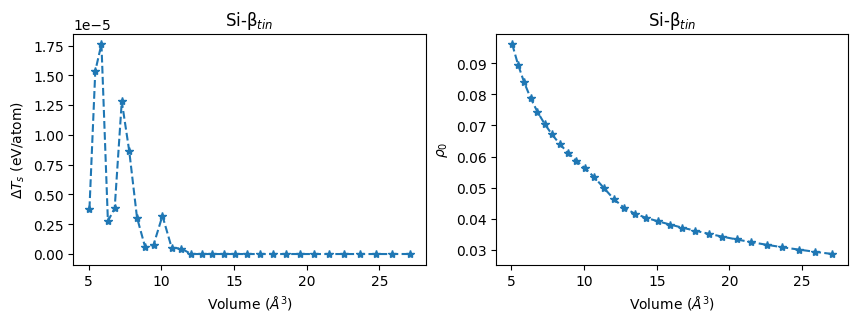

In [6]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(delta_E)*1/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(R0),'*--')
axs[0].set_title('Si-\u03B2$_{tin}$')
axs[1].set_title('Si-\u03B2$_{tin}$')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta T_{s}$ (eV/atom)')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')

In [7]:
np.save('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_fcc/DATA2/rho0_dTE', np.asarray(R0))